In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = '/content/drive/My Drive/dataset'

In [161]:
import os
print(os.getcwd())
os.chdir(path)
print(os.getcwd())

/content/drive/MyDrive/dataset
/content/drive/My Drive/dataset


In [6]:
!pip install pulp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 43.6 MB/s eta 0:00:00


In [162]:
import pandas as pd
from pulp import LpProblem, LpVariable, lpSum, LpMinimize, value

In [171]:
data = pd.read_csv('covid_vaccine_population.csv')

In [172]:
data.head()

,country,total_population,people_vaccinated,date,vaccines,source_name,source_website,unvaccinated
0,China,1400000000,2.160637e+07,2020,vaccines_China,National Health Commission,http://www.nhc.gov.cn/jkj/s7915/202203/d81d339...,unvaccinated_China
1,India,1300000000,2.058197e+08,2021,vaccines_India,Government of India,https://dashboard.cowin.gov.in/,unvaccinated_India
2,United States,331000000,8.002542e+07,2020,vaccines_United_States,Centers for Disease Control and Prevention,https://data.cdc.gov/Vaccinations/COVID-19-Vac...,unvaccinated_United_States
3,Brazil,213000000,4.344773e+07,2021,vaccines_Brazil,State governments via coronavirusbra1.github.io,https://coronavirusbra1.github.io,unvaccinated_Brazil
4,Indonesia,276000000,3.492632e+07,2021,vaccines_Indonesia,Government of Indonesia,https://data.covid19.go.id/public/index.html,unvaccinated_Indonesia


In [173]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   country            100 non-null    object 
 1   total_population   100 non-null    int64  
 2   people_vaccinated  100 non-null    float64
 3   date               100 non-null    int64  
 4   vaccines           100 non-null    object 
 5   source_name        100 non-null    object 
 6   source_website     100 non-null    object 
 7   unvaccinated       100 non-null    object 
dtypes: float64(1), int64(2), object(5)
memory usage: 6.4+ KB


In [177]:
data.describe()

,total_population,people_vaccinated,date
count,1.000000e+02,1.000000e+02,100.000000
mean,6.899100e+07,7.267646e+06,2020.690000
std,1.936514e+08,2.258790e+07,0.464823
min,1.300000e+06,3.913689e+04,2020.000000
25%,7.750000e+06,5.543381e+05,2020.000000
50%,1.900000e+07,1.392527e+06,2021.000000
75%,5.100000e+07,5.410949e+06,2021.000000
max,1.400000e+09,2.058197e+08,2021.000000


In [176]:
data.shape

(100, 8)

In [174]:
data.isna().sum()

country              0
total_population     0
people_vaccinated    0
date                 0
vaccines             0
source_name          0
source_website       0
unvaccinated         0
dtype: int64

In [178]:
data.columns

Index(['country', 'total_population', 'people_vaccinated', 'date', 'vaccines',
       'source_name', 'source_website', 'unvaccinated'],
      dtype='object')

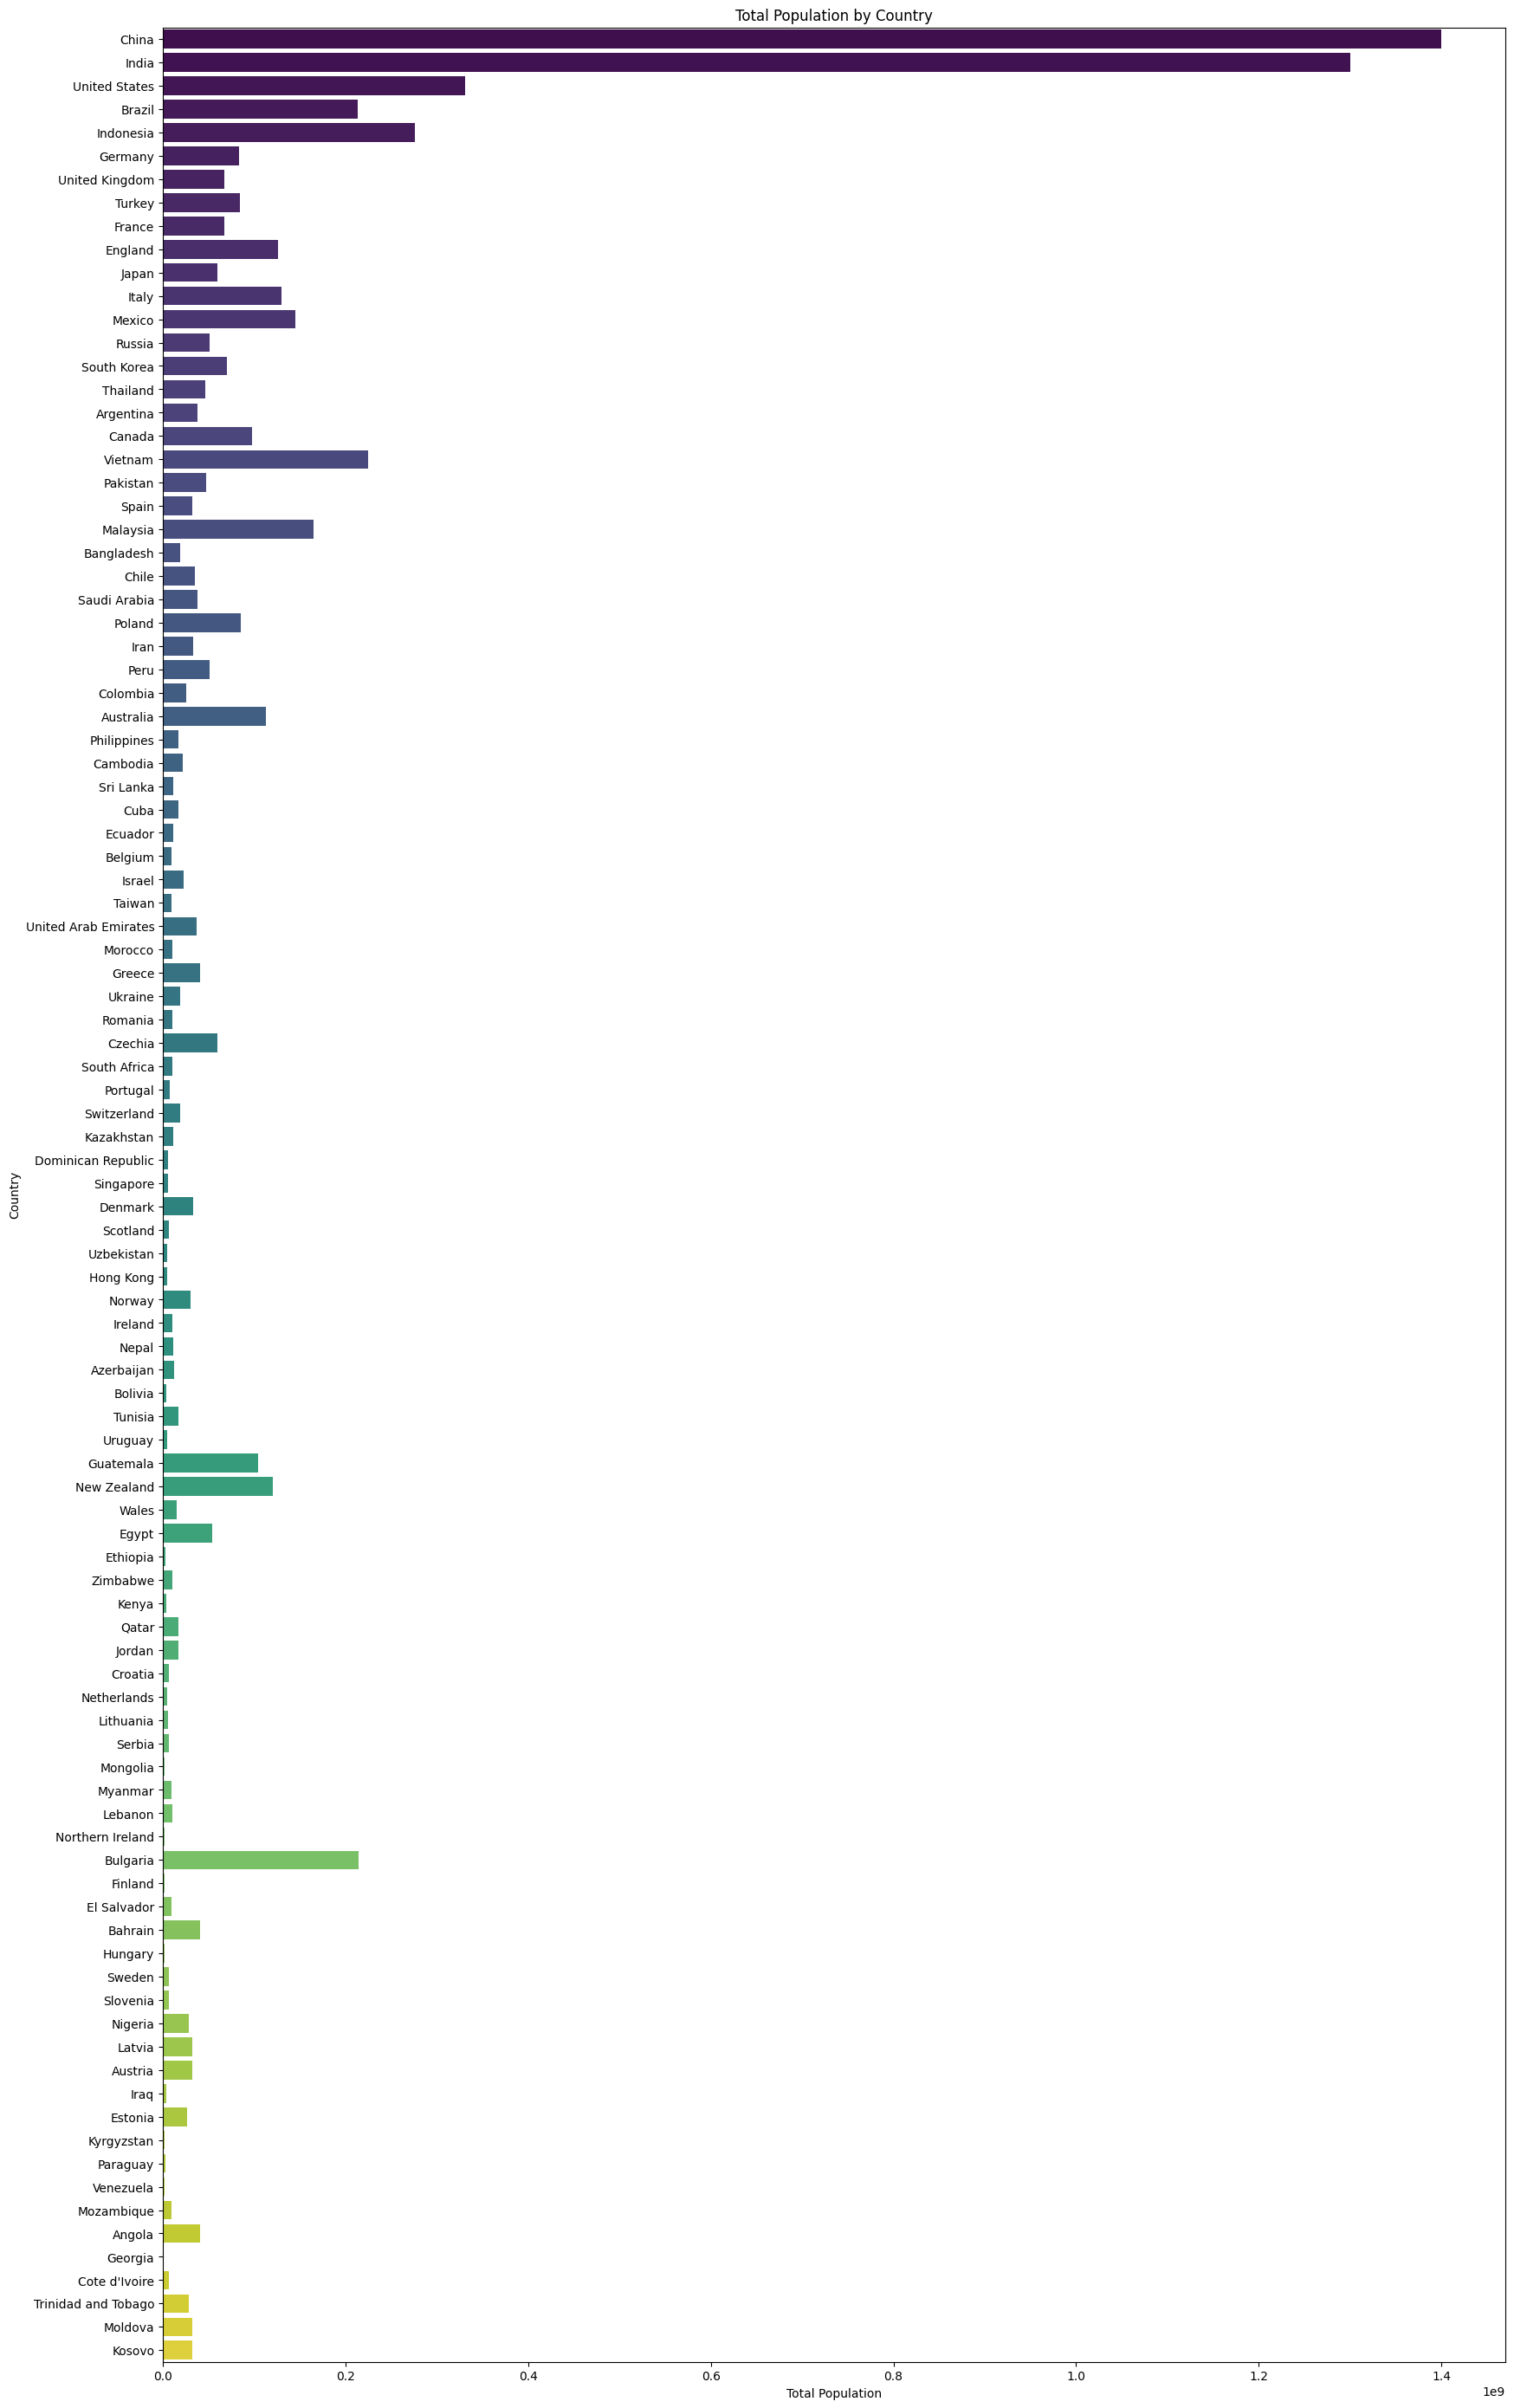

In [191]:
import matplotlib.pyplot as plt
import seaborn as sns

# Bar chart for total population by country
plt.figure(figsize=(20, 35))
sns.barplot(x='total_population', y='country', data=data, palette='viridis')
plt.title('Total Population by Country')
plt.xlabel('Total Population')
plt.ylabel('Country')
plt.show()

<ipython-input-206-20e86143b208>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_ten_countries_data.loc[:, 'unvaccinated_percent'] = ((top_ten_countries_data['total_population'] - top_ten_countries_data['people_vaccinated']) / top_ten_countries_data['total_population']) * 100


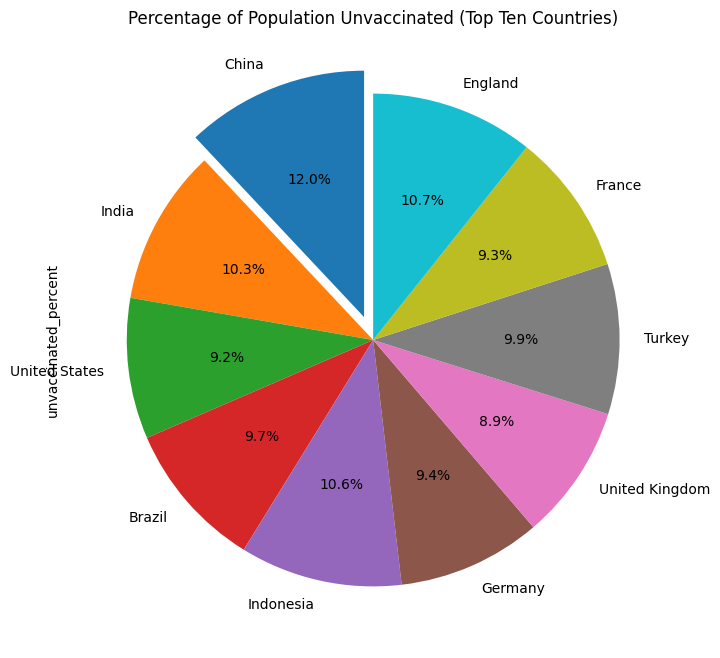

In [206]:
# Percentage of population unvaccinated for top ten populous countries

top_ten_countries_data = data.head(10)

top_ten_countries_data.loc[:, 'unvaccinated_percent'] = ((top_ten_countries_data['total_population'] - top_ten_countries_data['people_vaccinated']) / top_ten_countries_data['total_population']) * 100

# Pie chart for the percentage of population unvaccinated
plt.figure(figsize=(8, 8))
explode = [0.1] + [0] * (len(top_ten_countries_data) - 1)
labels = top_ten_countries_data['country']
top_ten_countries_data['unvaccinated_percent'].plot.pie(labels=labels, autopct='%1.1f%%', startangle=90, explode=explode)
plt.title('Percentage of Population Unvaccinated (Top Ten Countries)')
plt.show()


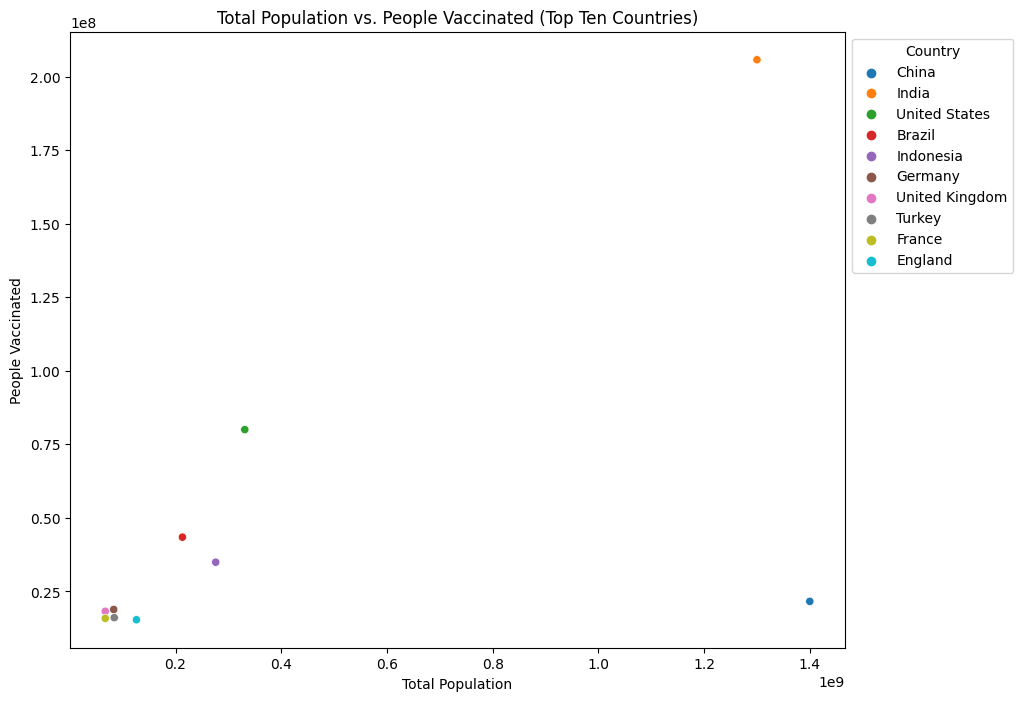

In [207]:
# Scatter plot for total population vs. people vaccinated for the top ten countries
plt.figure(figsize=(10, 8))
sns.scatterplot(x='total_population', y='people_vaccinated', data=top_ten_countries_data, hue='country', palette='tab10')
plt.title('Total Population vs. People Vaccinated (Top Ten Countries)')
plt.xlabel('Total Population')
plt.ylabel('People Vaccinated')
plt.legend(title='Country', loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


In [208]:
# linear programming problem
model = LpProblem(name="Vaccine_Optimization", sense=LpMinimize)

df = data

# setting decision Variables
df['vaccines'] = [LpVariable(f"vaccines_{country}", lowBound=0, cat="Integer") for country in df['country']]
df['unvaccinated'] = [LpVariable(f"unvaccinated_{country}", lowBound=0, cat="Integer") for country in df['country']]

# setting objective function: to minimize the total number of unvaccinated people
model += lpSum(df['unvaccinated'])

# constraint 1 : total vaccine supply
# assuming a total vaccine supply of 7 billion units
total_vaccine_supply = 7000000000
model += lpSum(df['vaccines']) <= total_vaccine_supply

# constraint 2 : number of unvaccinated people
for index, row in df.iterrows():
    model += row['unvaccinated'] == row['total_population'] - row['people_vaccinated'] - lpSum(row['vaccines'])

model.solve()

print("Optimal Vaccine Allocation:")
for index, row in df.iterrows():
    allocated_vaccines = value(row['vaccines'])
    print(f"Allocate {allocated_vaccines} vaccines to country {row['country']}")

# evaluating the objective value (total number of unvaccinated people)
total_unvaccinated = df['unvaccinated'].sum()
print("\nObjective Value - Total Unvaccinated People:", total_unvaccinated)


Optimal Vaccine Allocation:
Allocate 1378393600.0 vaccines to country China
Allocate 1094180300.0 vaccines to country India
Allocate 250974580.0 vaccines to country United States
Allocate 169552270.0 vaccines to country Brazil
Allocate 241073680.0 vaccines to country Indonesia
Allocate 64148201.0 vaccines to country Germany
Allocate 48761649.0 vaccines to country United Kingdom
Allocate 67923718.0 vaccines to country Turkey
Allocate 51156422.0 vaccines to country France
Allocate 110635380.0 vaccines to country England
Allocate 44832266.0 vaccines to country Japan
Allocate 115484630.0 vaccines to country Italy
Allocate 128513530.0 vaccines to country Mexico
Allocate 36355762.0 vaccines to country Russia
Allocate 59324070.0 vaccines to country South Korea
Allocate 35814955.0 vaccines to country Thailand
Allocate 27827341.0 vaccines to country Argentina
Allocate 88500577.0 vaccines to country Canada
Allocate 216026370.0 vaccines to country Vietnam
Allocate 36901664.0 vaccines to country P

In [209]:
# validating the first constraint : total vaccine supply
allocated_vaccines = df['vaccines'].apply(value)
total_allocated_vaccines = allocated_vaccines.sum()

if total_allocated_vaccines <= total_vaccine_supply:
    print("Total vaccine supply constraint satisfied.")
else:
    print("Total vaccine supply constraint NOT satisfied.")

# validating the second constraint : number of unvaccinated people
total_unvaccinated = df['unvaccinated'].apply(value).sum()

if total_unvaccinated == value(lpSum(df['unvaccinated'])):
    print("Number of unvaccinated people constraint satisfied.")
else:
    print("Number of unvaccinated people constraint NOT satisfied.")


Total vaccine supply constraint satisfied.
Number of unvaccinated people constraint satisfied.
